## Vehicel tracking

### 1. Feature extraction

Extract features from an image. We mainly focused on the HOG (Histogram of Oriented Gradient) and the color feature.

In [29]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog

#### 1.1 HOG feature

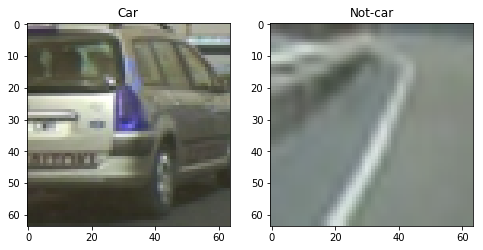

In [30]:
# Read a vehicle and non-vehicle image
vehicle_img = cv2.imread('vehicles/GTI_Left/image0168.png')
non_vehicle_img = cv2.imread('non-vehicles/GTI/image168.png')

fig = plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.title('Car')
plt.imshow(vehicle_img)
plt.subplot(122)
plt.title('Not-car')
plt.imshow(non_vehicle_img)
plt.show()

In [41]:
def get_hog_feature(image, orient, pix_per_cell, cell_per_block, vis, vec):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    
    
    if vis:
        features, hog_img = hog(gray, orientations=orient, 
                            pixels_per_cell = (pix_per_cell, pix_per_cell),
                            cells_per_block = (cell_per_block, cell_per_block),
                            block_norm = 'L2-Hys',
                            visualise = True,
                            transform_sqrt = True,
                            feature_vector = vec)
        return features, hog_img
    else:
        features = hog(gray, orientations=orient, 
                    pixels_per_cell = (pix_per_cell, pix_per_cell),
                    cells_per_block = (cell_per_block, cell_per_block),
                    block_norm = 'L2-Hys',
                    visualise = False,
                    transform_sqrt = True,
                    feature_vector = vec)
        return features

In [42]:
orient = 8
pix_per_cell = 8
cell_per_block = 2

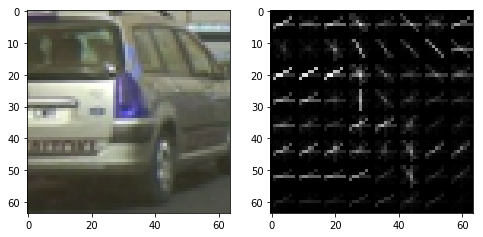

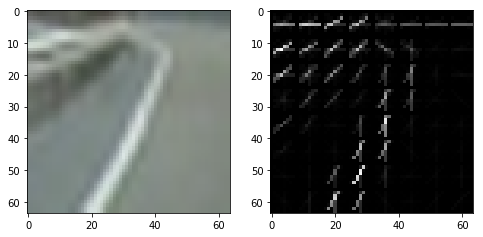

In [43]:
features, hog_img = get_hog_feature(vehicle_img, orient, pix_per_cell, cell_per_block, True, True)
fig = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(vehicle_img)
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.show()

features, hog_img = get_hog_feature(non_vehicle_img, orient, pix_per_cell, cell_per_block, True, True)
fig = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(non_vehicle_img)
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.show()

#### 1.2 color feature

In [5]:
# Convert image to grayscale and get HOG feature
def cvt_cspace(image, cspace='RGB'):
    if cspace == 'YCrCb':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif cspace == 'HSV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'LAB':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        img = image
    return img

def get_color_feature(image, cspace, channel, size, vis):
    img = cvt_cspace(image, cspace)
    small_img = cv2.resize(img, size)
    small_img = small_img[:,:,channel]
    feature_vec = small_img.ravel()
    if vis:
        return feature_vec, small_img
    else:
        return feature_vec

In [6]:
size = (32, 32)
cspace = 'YCrCb'
channel = 0

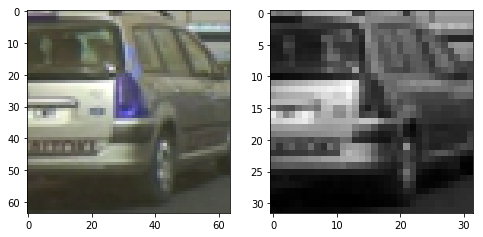

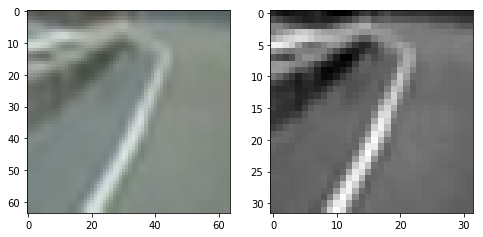

In [7]:
features, small_img = get_color_feature(vehicle_img, cspace, channel, size, True)
fig = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(vehicle_img)
plt.subplot(122)
plt.imshow(small_img, cmap='gray')
plt.show()

features, small_img = get_color_feature(non_vehicle_img, cspace, channel, size, True)
fig = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(non_vehicle_img)
plt.subplot(122)
plt.imshow(small_img, cmap='gray')
plt.show()

#### 1.3 Combine Features and normalize

1. color histogram
2. spatial bining
3. HOG

### 2. Train the model

Train the model using SVM.

#### 2.1 Read in car / not car images

In [58]:
import glob

car_files = glob.glob('./vehicles/*/*')
not_car_files = glob.glob('./non-vehicles/*/*')

car_imgs = []
not_car_imgs = []
for car_file in car_files:
    car_img = cv2.imread(car_file)
    car_imgs.append(car_img)
    
for not_car_file in not_car_files:
    not_car_img = cv2.imread(not_car_file)
    not_car_imgs.append(not_car_img)
    
print('Number of vehicle images:', len(car_imgs))
print('Number of non-vehicle images:', len(not_car_imgs))
print('Shape of the image:', car_imgs[0].shape)

Number of vehicle images: 8792
Number of non-vehicle images: 8968
Shape of the image: (64, 64, 3)


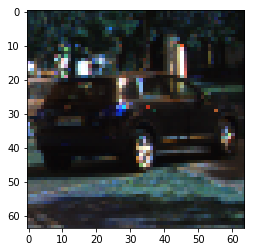

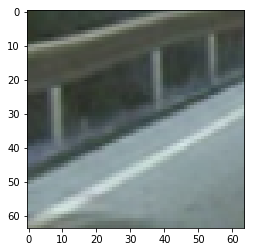

In [62]:
plt.imshow(car_imgs[8791])
plt.show()
plt.imshow(not_car_imgs[8967])
plt.show()

#### 2.2 Extract and normalize features.

1. Extract features
2. Normalize features
3. Split train/test data

In [74]:
# Extract features from images
def extract_features(imgs):
    features = []
    for img in imgs:
        vis = False
        vec = True
        feature = get_hog_feature(img, orient, pix_per_cell, cell_per_block, vis, vec)
        features.append(feature)
    return features

In [75]:
car_features = extract_features(car_imgs)
not_car_features = extract_features(not_car_imgs)
print(len(car_features))
print(len(not_car_features))
print(car_features[0].shape)
print(car_features[0].dtype)

8792
8968
(1568,)
float64


In [76]:
X = np.vstack((car_features, not_car_features))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
print(X.shape)
print(y.shape)

(17760, 1568)
(17760,)


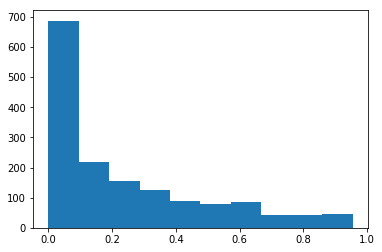

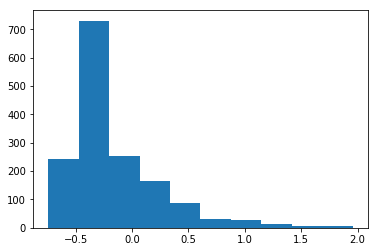

(17760, 1568)


In [79]:
# Normalize
from sklearn.preprocessing import StandardScaler

plt.hist(X[0])
plt.show()

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

plt.hist(scaled_X[0])
plt.show()
print(scaled_X.shape)

In [81]:
# Split data
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14208, 1568)
(14208,)
(3552, 1568)
(3552,)


#### 2.3 Train model

In the first round, I use non-linear SVM with GridSearch method. In this way, we can pick up the best parameters for the use of this algorithm.

In [82]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print(acc)

0.925957207207


### 3. Sliding Window Search

In [96]:
"""
Given a list of bounding boxes, draw them on the image.
"""
def draw_boxes(image, bboxes, color=(0, 0, 255), thickness=6):
    img = np.copy(image)
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], color, thickness)
    return img

#### 3.1 Same window size

Let's implement the very basic version of searching algorithm. It creates sliding windows with the same size.

In [150]:
def slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Range in x,y direction
    range_x = x_start_stop[1] - x_start_stop[0]
    range_y = y_start_stop[1] - y_start_stop[0]
    # Pixels per step in x,y direction
    x_step_pix = np.int(xy_window[0] * (1-xy_overlap[0]))
    y_step_pix = np.int(xy_window[1] * (1-xy_overlap[1]))
    # Buffer in x,y direction
    x_buffer = np.int(xy_window[0] * xy_overlap[0])
    y_buffer = np.int(xy_window[1] * xy_overlap[1])
    # Number of windows
    n_win_x = np.int((range_x - x_buffer)/x_step_pix)
    n_win_y = np.int((range_y - y_buffer)/y_step_pix)
    
    bboxes = []
    for i in range(n_win_x):
        for j in range(n_win_y):
            top_left_x = x_step_pix * i + x_start_stop[0]
            top_left_y = y_step_pix * j + y_start_stop[0]
            bottom_right_x = top_left_x + xy_window[0]
            bottom_right_y = top_left_y + xy_window[1]
            bboxes.append(((top_left_x, top_left_y), (bottom_right_x, bottom_right_y)))
    return bboxes

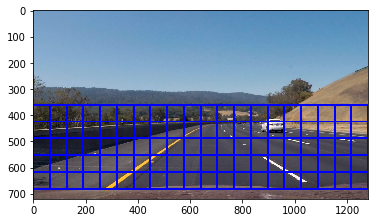

In [151]:
img = mpimg.imread('./test_images/test3.jpg')

bboxes = slid_win(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], 
                    xy_window=(128, 128))
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()

#### 3.2 Perspective sliding windows

Perspective sliding windows take into the account of perspective transformation. The farther the window it is, the smaller it appears; The closer the window it is, the larger it appears.

In [152]:
"""
Multiscale sliding window. 
Ratio: (1 + y_distance * ratio) would be the size of a new window
"""
def perspective_slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5), ratio=1/300.):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
     
    bboxes = []
    win = xy_window # current window size
    top = y_start_stop[0] # upper bound of bbox
    bottom = top + win[1] # lower bound of bbox
    
    while bottom <= y_start_stop[1]:
        left = x_start_stop[0]
        right = left + win[0]
        pix_x = np.int(win[0]*(1-xy_overlap[0])) # pixel per step in x direction
        while right <= x_start_stop[1]:
            bboxes.append(((left, top), (right, bottom)))
            left += pix_x
            right = left + win[0]
        # update window size
        pix_y = np.int(win[1]*(1-xy_overlap[1])) # pixel per step in y direction
        scale = 1 + pix_y * ratio
        win_x = np.int(win[0]*scale)
        win_y = np.int(win[1]*scale)
        win = (win_x, win_y)
        top += pix_y
        bottom = top + win[1]
    return bboxes

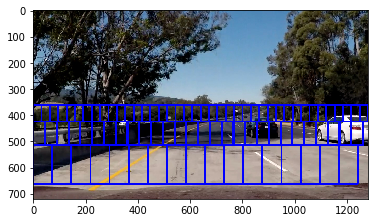

In [157]:
img = mpimg.imread('./test_images/test5.jpg')

bboxes = perspective_slid_win(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], xy_window=(64, 64), xy_overlap=(0.5, 0), ratio=1/150.)
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()